# Decision Tree Regressor

### Theory

In this notebook, we will implement the CART algorithm for a decision tree regressor. The growth algorithm remains unchanged from that of the _DecisionTreeClassifier_, but our criterion to determine the best split is different. Rather than considering node puritiy via the Gini coefficient, we consider the sum of squared errors (SSE) of the children nodes. Specifically, the best split is one that minimises the weighted SSE of the children nodes. Let us say that we split a parent node $P$ into the children nodes $C_L$ and $C_R$, the weighted SSE resulting from this split is computed as,

$$\text{SSE} = \frac{N_L}{N} \sum_{i \in C_L}^{N_L}(y_i - \bar{y}_{L})^{2} + \frac{N_R}{N} \sum_{i \in C_R }^{N_R}(y_i - \bar{y}_{R})^{2}$$

In which, $P = C_L \cup C_R$ are the sets of samples contained within the parent and children nodes respectively, $N$ is the number of samples in the parent node, $N_L$ for the left child node and $N_R$ for the right child node. $\bar{y}_{L}$ and $\bar{y}_{R}$ are also the average of the targets within each node such that,

$$
\begin{array}{cc}
\bar{y}_{L} = \dfrac{1}{N_L}\sum\limits_{i \in C_L}^{N_L}{y_i} & 
\bar{y}_{R} = \dfrac{1}{N_R}\sum\limits_{i \in C_R}^{N_R}{y_i}
\end{array}
$$

One many also consider the weighted MSE of the children nodes which simplifies to,

$$\text{MSE} = \frac{1}{N} \left( \sum_{i \in C_L}^{N_L}(y_i - \bar{y}_{L})^{2} + \sum_{i \in C_R }^{N_R}(y_i - \bar{y}_{R})^{2} \right)$$

Either can be used to quantifiy the impurity decrease from splitting a parent node into children nodes. Let us denote this impurity decrease as $\Delta \mathcal{P} = \mathcal{P}_{P} - \mathcal{P}_C$,

$$\Delta \mathcal{P} = \sum_{i \in P}^{N}(y_i - \bar{y}_{P})^{2} - \frac{N_L}{N} \sum_{i \in C_L}^{N_L}(y_i - \bar{y}_{L})^{2} + \frac{N_R}{N} \sum_{i \in C_R }^{N_R}(y_i - \bar{y}_{R})^{2}$$

Now we are able to rephase our optimisation problem into: We want to find the optimal split with the threshold value $\theta_j$ for the feature $j$ which maximises the impurity decrease $\Delta \mathcal{P}$. This is analgous to the _DecisionTreeClassifier_, but with weighted SSE, MSE or any other similiar metric used as a proxy for node impurity rather than the Gini coefficient. Likewise, in cost-complexity pruning (CCP) our algorithm remains the exactly the same, but the effective cost of each internal node $C_m$ is calculated using a different measure of impurity. The pruning rule is,

$$\alpha \geq \frac{R_m - R(\mathcal{T}_m)}{(\mathcal{N}_m - 1)} = C_{m}$$

where the risk of the $m$-th node $R_m$ and its sub-tree $R(\mathcal{T}_m)$ is calculated from,

$$
\begin{array}{cc}
R_m = p_m \mathcal{P}_m & 
R(\mathcal{T}_{m}) = \sum_{j \in L_m} R_j
\end{array}
$$

Note that $p_m = N_m/N$ is the proportion of samples in the $m$-th node compared to the entire dataset such that $N$ is this case is total number of samples. Finally, in feature importance analysis our formula to calculate the normalised importance of a given feature $j$ is given by,

$$\bar{\mathcal{I}}_j = \frac{\sum_{m \in F_j} P_{\int, m} (\Delta \mathcal{P}_{m})}{\sum_{j}^{M} \mathcal{I}_j}$$

For clarification, $\Delta \mathcal{P}_{m}$ is the decrease in impurity which occurs when the $m$-th node is split into its respective children node. With this all of this in mind, our implementation of the _DecisionTreeRegressor_ is as follows,

### Implementation

In [ ]:
# Importing,
import numpy as np
import copy

class DecisionTreeRegressor():
    """The class for the DecisionTreeRegressor model. Includes CCP pruning and feature importance analysis."""

    def __init__(self, max_depth=None, min_samples_leaf=1, min_samples_split=2, criterion="MSE", feature_subsampling=False, label=False):
        """Constructor method for the DecisionTreeRegressor class. We simply create the class variables."""

        # Class variables for the data and nodes,
        self.X, self.y, self.tree_root = None, None, None
        self.n_samples = None
        self.model_score = None
        self.ccp_alpha = None
        self.label = "tree" if not label else label

        # Stopping criteria,
        if max_depth is None:
            self.max_depth = np.inf
        else:
            self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split

        # Split criterion,
        self.criterion = criterion
        self.feature_subsampling = feature_subsampling
        self.feature_idxs = None

        # Feature importances vector,
        self.feature_importances = None
        self.feature_importances_idxs = None

        return None

    def fit(self, X, y):
        """Use this method to fit the tree to the training dataset."""

        # Assignment to class attributes,
        self.X, self.y = X, y
        self.n_samples, self.n_features = X.shape[0], X.shape[1]

        # Storing the indices of the features,
        self.feature_idxs = np.arange(start=0, stop=self.n_features, step=1)
        self.n_sampled_features = int(np.ceil(np.sqrt(self.n_features))) # <-- Number of features selected if random features enabled.

        # Growing the tree,
        self.tree_root = self._grow_tree(X=X, y=y, node_label="O", current_depth=0) # <-- The label "O" is for the root node.

        return None

    def predict(self, X):
        """Wrapper method around _traverse_tree() for predictions."""

        # Traversing the tree,
        preds = np.asarray([self._traverse_tree(x, self.tree_root) for x in X]) # <-- Starting at the root node.

        return preds

    def score(self, X, y):
        """Computes the accuracy of the model on the given testing data. In the case of regression, the 
        coefficient of determination or R^2 coefficient is calculated."""

        # Storing predictions as an array,
        y_preds = self.predict(X)

        # Computing R2 coefficient as the score,
        SS_res = np.sum((y - y_preds)**2)
        SS_total = np.sum((y - np.mean(y))**2)
        score = 1 - (SS_res/SS_total)

        # Assigning score,
        self.model_score = score

        return score

    def print_tree(self, structural=True):
        """Prints the structure of the tree using _traverse_tree_print which traverses the tree."""
        n_nodes = self._traverse_tree_print(node=self.tree_root, structural=structural)
        print(f"Number of nodes: {n_nodes}")
        return None

    def prune(self, alpha, inplace=True):
        """Calling this function performs cost-complexity pruning on the existing tree or a copy based on 
         a given hyperparameter alpha."""

        if inplace:
            self._compute_cpp_info(node=self.tree_root)
            self._prune_tree(node=self.tree_root, alpha=alpha)
            self.ccp_alpha = alpha
            return None
        else:
            clone_tree = copy.deepcopy(self) # <-- Copy of the tree is created.
            self._compute_cpp_info(node=clone_tree.tree_root)
            self._prune_tree(node=clone_tree.tree_root, alpha=alpha)
            clone_tree.ccp_alpha = alpha
            return clone_tree
        
    def compute_importances(self, norm=True):
        """Call this function returns the importances of each feature as an array."""

        # Initialising importances array,
        self.feature_importances = np.zeros(shape=self.X.shape[1])

        # Computing importances,
        self._compute_importances(node=self.tree_root, prob_acc=1)

        # Normalising importances (default behaviour),
        if norm:
            self.feature_importances = self.feature_importances/self.feature_importances.sum()

        # Storing the sorted feature importances indices,
        self.feature_importances_idxs = np.argsort(self.feature_importances)[::-1]

        return self.feature_importances

    def _grow_tree(self, X, y, node_label, current_depth):
        """This function is recursively called and is responsible for the creation of the tree. The function is called every time we create a new node in the tree."""

        # Creating node object,
        current_node = Node(X, y, node_label)
        current_node.impurity = self._compute_impurity(y_node=y)

        """STOPPING CRITERIA: maximum depth reached."""
        if current_depth == self.max_depth:

            # Marking as leaf node,
            current_node.is_leaf = True

            # Computing prediction for leaf node,
            current_node.prediction = self._compute_prediction(y_node=current_node.y)

            # Returning leaf node,
            return current_node
        
        """STOPPING CRITERIA: parent node has equal or fewer than min_samples_split number of data points."""
        if len(y) < self.min_samples_split:
            current_node.is_leaf = True
            current_node.prediction = self._compute_prediction(y_node=current_node.y)
            return current_node

        # Splitting node,
        decision, children_data, node_labels, valid_split = self._split(X, y, parent_node=current_node)

        if valid_split: # <-- The case when we have a valid split.

            # Assigning decision to current node,
            current_node.decision = decision
        
            # Unpacking children data,
            X_left, X_right, y_left, y_right = children_data
            left_node_label, right_node_label = node_labels

            # Creating subtrees,
            current_depth += 1
            current_node.child_left = self._grow_tree(X=X_left, y=y_left, node_label=left_node_label, current_depth=current_depth) # <-- We grow the branch from the left node first.
            current_node.child_right = self._grow_tree(X=X_right, y=y_right, node_label=right_node_label, current_depth=current_depth) # <-- We backtrack and then grow the branches from the right nodes.

            # Returning our current node,
            return current_node

        else: #<-- The case when we do NOT have a valid split,

            # Our current node must be a leaf node,
            current_node.is_leaf = True
            current_node.prediction = self._compute_prediction(y_node=current_node.y)
            return current_node

    def _split(self, X, y, parent_node):
        """Binary splits a parent node into two child nodes based on the decision that mimises the SSE (sum of squared errors) of the
        children nodes."""

        # Placeholder variables,
        min_impurity = np.inf
        split_threshold_value = None
        found_split = False
        X_best_left_split, X_best_right_split, y_best_left_split, y_best_right_split = None, None, None, None

        # Extract the SE of of parent node,
        parent_impurity = parent_node.impurity
        selected_feature_idxs = np.random.choice(self.feature_idxs, size=self.n_sampled_features, replace=True) if self.feature_subsampling else self.feature_idxs

        # Double loop, first for each feature, second for each threshold value,
        for feature_idx in selected_feature_idxs:

            # Extracting feature values,
            X_feature = X[:, feature_idx]
            
            # Thresholds taken as the midpoint between sorted values,
            X_feature_sorted = np.sort(X_feature)
            thresholds = np.unique((X_feature_sorted[:-1] + X_feature_sorted[1:]) / 2)

            for threshold_value in thresholds:

                # Splitting data in parent node into child nodes,
                left_split_idxs, right_split_idxs = np.where(X_feature <= threshold_value)[0], np.where(X_feature > threshold_value)[0]
                X_left_split, X_right_split = X[left_split_idxs], X[right_split_idxs]
                y_left_split, y_right_split = y[left_split_idxs], y[right_split_idxs]

                # Reject splits which result in child nodes having less data points that the minimum number,
                if len(left_split_idxs) <= self.min_samples_leaf or len(right_split_idxs) <= self.min_samples_leaf:
                    continue

                # Compute weighted SSE of children nodes,
                children_impurity = (len(y_left_split)/len(y))*self._compute_impurity(y_node=y_left_split) + (len(y_right_split)/len(y))*self._compute_impurity(y_node=y_right_split)

                # Calculating the impurity decrease,
                impurity_decrease = parent_impurity - children_impurity

                # Tracking minimum SSE,
                if children_impurity < min_impurity:

                    # Reassigning minimum SSE,
                    min_impurity = children_impurity
                    parent_node.impurity_decrease = impurity_decrease
                    found_split = True

                    # Updating nodes associated with the best split,
                    split_threshold_value, split_feature = threshold_value, feature_idx
                    X_best_left_split, X_best_right_split, y_best_left_split, y_best_right_split = X_left_split, X_right_split, y_left_split, y_right_split

        if found_split: # <-- Case 1: We have found a valid split.

            # Packaging data to return,
            node_labels = ((parent_node.label + "L"), (parent_node.label + "R"))
            decision = (split_feature, split_threshold_value)
            children_data = (X_best_left_split, X_best_right_split, y_best_left_split, y_best_right_split)

            # Assigning node decision,
            parent_node.decision = decision

            return decision, children_data, node_labels, found_split
        else: #<-- Case 2: No valid split was found.
            return None, None, None, found_split

    def _traverse_tree(self, X_sample, node):
        """Helper function for traversing the tree recurvisely in order to make predictions."""

        if node.is_leaf: # <-- Reached terminal node.
            return node.prediction

        else: # <-- Node has a decision.
    
            # Extracting decision information,
            feature, feature_threshold = node.decision

            # Making decision,
            if X_sample[feature] <= feature_threshold:
                return self._traverse_tree(X_sample=X_sample, node=node.child_left)
            else:
                return self._traverse_tree(X_sample=X_sample, node=node.child_right)

    def _traverse_tree_print(self, node, structural, current_depth=0):
        """Traverses the tree via recursion."""

        # Counting the current node,
        node_count = 1

        if structural:

            # Printing maintains tree structure (pretty),
            indent = "  " * current_depth
            if node.is_leaf:
                print(f"{indent}Leaf → Predict: {node.prediction}")
            else:
                print(f"{indent}If X[:, {node.decision[0]}] <= {node.decision[1]}")
                node_count += self._traverse_tree_print(node.child_left, structural, current_depth + 1)
                print(f"{indent}Else:")
                node_count += self._traverse_tree_print(node.child_right, structural, current_depth + 1)

        else:
            if node.is_leaf:
                print(f"Node: {node.label}, Prediction: {node.prediction}, Impurity: {node.impurity}")
            else:
                print(f"Node: {node.label}, Decision: {node.decision}")
                node_count += self._traverse_tree_print(node.child_left, structural, current_depth + 1)
                node_count += self._traverse_tree_print(node.child_right, structural, current_depth + 1)

        # Returning node count,
        return node_count
    
    def _prune_tree(self, node, alpha):
        """Recursive function which prunes the tree."""

        # If the current node is a leaf, we cannot prune it,
        if node.is_leaf:
            return
        
        if node.child_left is not None:
            self._prune_tree(node.child_left, alpha)
        if node.child_right is not None:
            self._prune_tree(node.child_right, alpha)

        # If both children are leaf nodes, we now consider pruning the current node,
        if node.child_left is not None and node.child_right is not None:
            if node.child_left.is_leaf and node.child_right.is_leaf:

                # Pruning logic,
                if node.effective_cost <= alpha:

                    # Cutting off branch,
                    node.child_left, node.child_right = None, None

                    # Converting internal node into leaf node,
                    node.is_leaf = True
                    node.prediction = self._compute_prediction(y_node=node.y)
                    node.decision = None

    def _compute_cpp_info(self, node):
        """This method traverses the tree to compute the effective cost of each node which is required for cost-complexity pruning (CPP). It
        uses post-order traversal which finds the deepest part of the tree and works its from up starting from the left."""

        if node.is_leaf:
        
            # Computing risk,
            node_risk = self._compute_node_risk(node)
            return 1, node_risk

        # Resetting counts,
        n_leaves_accumulated, risk_accumlated = 0, 0

        # Post-order computation,
        subtree_nleaves_left, subtree_risk_left = self._compute_cpp_info(node.child_left)
        subtree_nleaves_right, subtree_risk_right = self._compute_cpp_info(node.child_right)

        # Computing number of leaves, risk and effective cost of subtree,
        n_leaves_accumulated += (subtree_nleaves_left + subtree_nleaves_right)
        risk_accumlated += (subtree_risk_left + subtree_risk_right)
        node_risk = self._compute_node_risk(node) # <-- Computing the risk of the current node (root of current sub-tree)
        effective_cost = (node_risk - risk_accumlated)/(n_leaves_accumulated - 1)

        # Assigning node attributes,
        node.effective_cost = effective_cost

        return n_leaves_accumulated, risk_accumlated
    
    def _compute_importances(self, node, prob_acc):
        """Recursive method for computing the feature importances."""

        # Assigning the probability of the node,
        node.prob = prob_acc

        if node.is_leaf:
            return 
        else:
            # Computing the importance contribution,
            importance_contribution = prob_acc*node.impurity_decrease
            feature_idx = int(node.decision[0])
            self.feature_importances[feature_idx] += importance_contribution

            # Computing probabilities,
            n_parent, n_left, n_right = len(node.y), len(node.child_left.y), len(node.child_right.y)
            prob_acc_left, prob_acc_right = prob_acc*(n_left/n_parent), prob_acc*(n_right/n_parent)

            # Recursion,
            self._compute_importances(node.child_left, prob_acc_left)
            self._compute_importances(node.child_right, prob_acc_right)
    
    def _repr_html_(self):
        """Compact HTML GUI as the object representation in Jupyter Notebook."""
        html = f"""
        <div style="
            border:1px solid black;
            border-radius:6px;
            font-family:Arial, sans-serif;
            font-size:12px;
            line-height:1.2;
            width:fit-content;
            background:white;
            color:black;
            padding-left:8px;
            padding-right:8px;
        ">
            <!-- Title bar -->
            <i>{self.label}</i>
            <div style="
                background:#e0e0e0;
                padding:3px 6px;
                font-weight:bold;
                border-bottom:1px solid black;
                border-top-left-radius:6px;
                border-top-right-radius:6px;
                color:black;
            ">
                DecisionTreeRegressor
                <div style="margin-top:2px;">
                    <img src="decisiontree_icon.png" alt="tree icon" width="30" height="45">
                </div>
            </div>

            <!-- Hyperparameters -->
            <ul style="margin:4px 0 4px 16px; padding:0;">
                <b>Hyperparameters:</b><br>
                ccp_alpha:</b> {self.ccp_alpha}<br>
                max_depth:</b> {self.max_depth}<br>
                min_samples_leaf:</b> {self.min_samples_leaf}<br>
                min_samples_split:</b> {self.min_samples_split}<br>
                criterion: {self.criterion}<br>
                feature_subsampling: {self.feature_subsampling}
            </ul>

            <!-- Divider -->
            <div style="
                border-top:1px solid #ccc;
                margin:4px 0;
            "></div>

            <!-- Status and other info -->
            <ul style="margin:4px 0 4px 16px; padding:0;">
        """

        if self.tree_root is None:
            html += "<b>Status:</b> <span style='color:red;'>Not fitted</span>"
        else:
            html += "<b>Status:</b> <span style='color:green;'>Fitted</span><br>"
            html += f"Score (R^2):</b> {self.model_score}<br>"
            html += f"n_samples:</b> {self.n_samples}<br>"
            html += f"n_features:</b> {self.n_features}<br>"
            html += f"feature_importances_idxs:</b> {self.feature_importances_idxs}<br>"

        html += "</ul></div>"
        return html

    def _compute_impurity(self, y_node):
        if self.criterion == "SSE":
            return np.sum((y_node - np.mean(y_node))**2)
        elif self.criterion == "MSE":
            return np.mean((y_node - np.mean(y_node))**2)
        
    def _compute_node_risk(self, node):
        return (len(node.y)/len(self.y))*node.impurity

    @staticmethod
    def _compute_prediction(y_node):
        return np.mean(y_node)

class Node():
    """The class for node objects. Essentially used as a container."""

    def __init__(self, X, y, node_label):
        """Constructor method for the node. Class variables contain node information and encode its location in the tree
        required for predictions."""

        # Node information,
        self.X, self.y = X, y
        self.is_leaf = False
        self.decision = None
        self.prediction = None
        self.impurity = None
        self.impurity_decrease = None
        self.effective_cost = None

        # Encodes location in the tree,
        self.label, self.child_left, self.child_right = node_label, None, None


### Basic Regression Example


For a very basic test, let us compare how well our model can perform regression for the curve $y = \sin{(X)}$ compared to sci-kit learn's standard implementation:

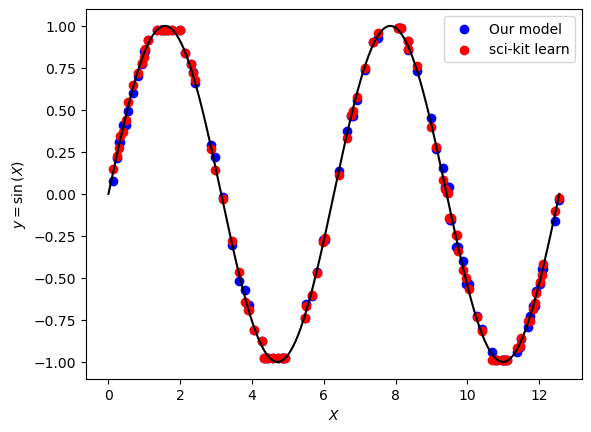

R2 (our model): 0.9980195443764682, R2 (sci-kit): 0.998802666441125


In [34]:
# Importing,
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor as SKDecisionTreeRegressor
import matplotlib.pyplot as plt

# Creating dataset,
X = np.linspace(start=0, stop=4*np.pi, num=500)
y = np.sin(X)
X = X.reshape(-1, 1) # <-- Transforming into correct shape.

# Creating data split,
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Fitting the models,
regressor = DecisionTreeRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=2)
regressor.fit(X_train, y_train)
sk_regressor = SKDecisionTreeRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=2)
sk_regressor.fit(X_train, y_train)

# Computing R2 score,
r2 = regressor.score(X_test, y_test)
sk_r2 = sk_regressor.score(X_test, y_test)

# Calculating predictions,
y_pred = regressor.predict(X_test)
y_pred_sk = sk_regressor.predict(X_test)

# Plotting,
plt.plot(X, y, color="black")
plt.scatter(X_test, y_pred, color="blue", label="Our model")
plt.scatter(X_test, y_pred_sk, color="red", label="sci-kit learn")
plt.ylabel(r"$y=\sin{(X)}$")
plt.xlabel(r"$X$")
plt.legend()
plt.show()

# Printing,
print(f"R2 (our model): {r2}, R2 (sci-kit): {sk_r2}")

However, we do see that there is a very slight discrepancy in predictive power in favour of the sci-learn implementation. Furthermore, there is a difference in the structure of the trees. Our implementation has more nodes and a different sub-tree from the left branch of the root node. We may explain these differences due to, 

- Our Approach: Uses midpoint thresholds between sorted values, does not use tie-breaking rules and treats all features with equal importance.
- Scikit-learn: Generates thresholds from histogram methods, tie-breaking rules are used and global feature importance is dynamically considerd when making splits.


### House Price Prediction Example

Let us create the fully grown tree,

In [39]:
# Importing,
from sklearn.datasets import fetch_california_housing

# Creating dataset,
housing_dataset = fetch_california_housing(as_frame=False)
X, y = housing_dataset.data[:1000], housing_dataset.target[:1000]

# Splitting data,
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating full grown tree,
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)
score = regressor.score(X_test, y_test)

# Repeating for sci-kit implementation,
sk_regressor = SKDecisionTreeRegressor(random_state=0)
sk_regressor.fit(X_train, y_train)
sk_score = sk_regressor.score(X_test, y_test)

# Printing scores,
print(f"Ours: {score}, Sci-kit: {sk_score}")

Ours: 0.5544447588936159, Sci-kit: 0.5232408626051563


Now we progressively prune the tree and find the best model,

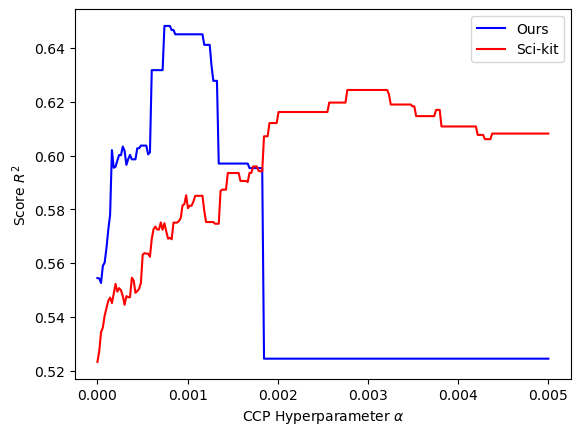

Our best model:


In [29]:
# Creating alphas,
ccp_alphas = np.linspace(start=0, stop=0.005, num=250)
regressors = []
sk_regressors = []
scores = []
sk_scores = []

# Progressively pruning the full tree,
for ccp_alpha in ccp_alphas:

    # Creating pruned trees,
    regressor_pruned = regressor.prune(alpha=ccp_alpha, inplace=False)
    regressors.append(regressor_pruned)

    sk_regressor_pruned = SKDecisionTreeRegressor(ccp_alpha=ccp_alpha, random_state=0)
    sk_regressor_pruned.fit(X_train, y_train)
    sk_regressors.append(sk_regressor_pruned)

    # Scoring the pruned trees,
    score = regressor_pruned.score(X_test, y_test)
    scores.append(score)

    sk_score = sk_regressor_pruned.score(X_test, y_test)
    sk_scores.append(sk_score)

# Plotting,
plt.plot(ccp_alphas, scores, color="blue", label="Ours")
plt.plot(ccp_alphas, sk_scores, color="red", label="Sci-kit")
plt.xlabel(r"CCP Hyperparameter $\alpha$")
plt.ylabel(r"Score $R^2$")
plt.legend()
plt.show()

# Printing,
best_alpha = ccp_alphas[np.argmax(scores)]
best_regressor = regressors[np.argmax(scores)]
print("Our best model:")
best_regressor.score(X_test, y_test)
best_regressor.label = "Best Regressor"
best_regressor


Finally, we conduct feature importance analysis,

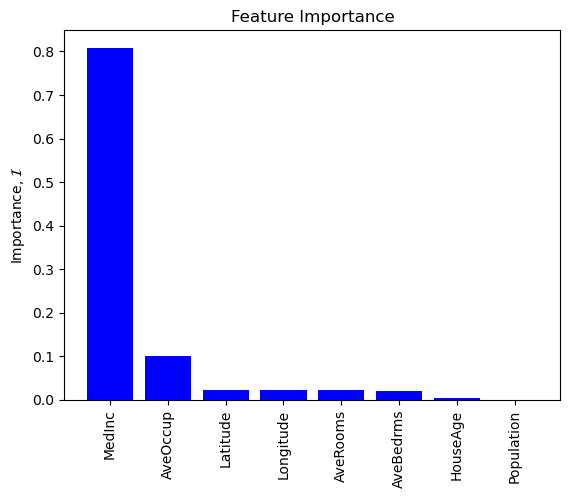

In [30]:
# Computing feature importances,
importances = best_regressor.compute_importances()

# Sorting features by on their importances,
idxs_sorted = np.argsort(importances)[::-1]
importances_sorted = importances[idxs_sorted]
feature_names_sorted = np.asarray(housing_dataset.feature_names)[idxs_sorted]

# Plotting,
fig, ax = plt.subplots()
ax.bar(feature_names_sorted, importances_sorted, color="blue")
ax.set_ylabel(r"Importance, $\mathcal{I}$")
ax.set_title("Feature Importance")
plt.xticks(rotation=90)
plt.show()